In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

In [3]:
test = pd.read_csv(r"C:\Users\jiahe\OneDrive\Desktop\kaggle\test.csv")
train = pd.read_csv(r"C:\Users\jiahe\OneDrive\Desktop\kaggle\train.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()

Train shape: (517754, 14)
Test shape: (172585, 13)


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [3]:
train.isnull().sum().sort_values(ascending=False).head(10)

id                    0
road_type             0
num_lanes             0
curvature             0
speed_limit           0
lighting              0
weather               0
road_signs_present    0
public_road           0
time_of_day           0
dtype: int64

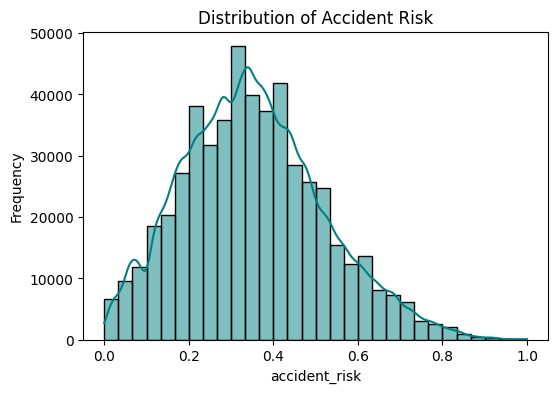

In [4]:
plt.figure(figsize=(6,4))
sns.histplot(train['accident_risk'], bins=30, kde=True, color='teal')
plt.title("Distribution of Accident Risk")
plt.xlabel("accident_risk")
plt.ylabel("Frequency")
plt.show()

Categorical columns: ['road_type', 'lighting', 'weather', 'time_of_day']

Weather distribution among high-risk accidents:
weather
foggy    0.556579
rainy    0.375705
clear    0.067716
Name: proportion, dtype: float64


C:\Users\jiahe\AppData\Local\Temp\ipykernel_20072\448169758.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='weather', y='accident_risk', data=train, palette='pastel')


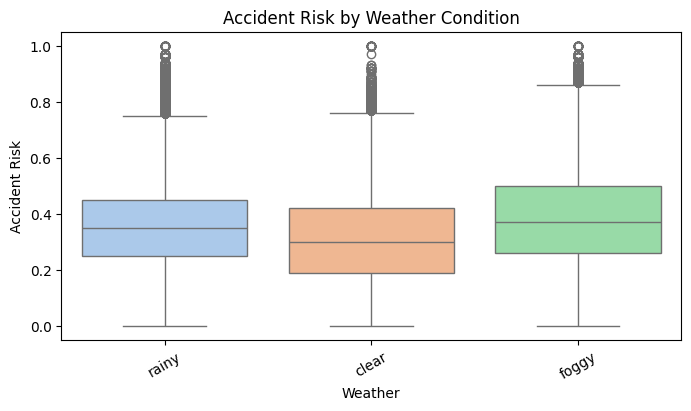

In [4]:
# Identify categorical columns
cat_cols = train.select_dtypes(include=['object']).columns
print("Categorical columns:", list(cat_cols))

# Inspect high-risk weather distribution
high_risk = train[train['accident_risk'] > 0.8]
print("\nWeather distribution among high-risk accidents:")
print(high_risk['weather'].value_counts(normalize=True))

# Boxplot: Accident risk by weather condition
plt.figure(figsize=(8,4))
sns.boxplot(x='weather', y='accident_risk', data=train, palette='pastel')
plt.title("Accident Risk by Weather Condition")
plt.xlabel("Weather")
plt.ylabel("Accident Risk")
plt.xticks(rotation=30)
plt.show()

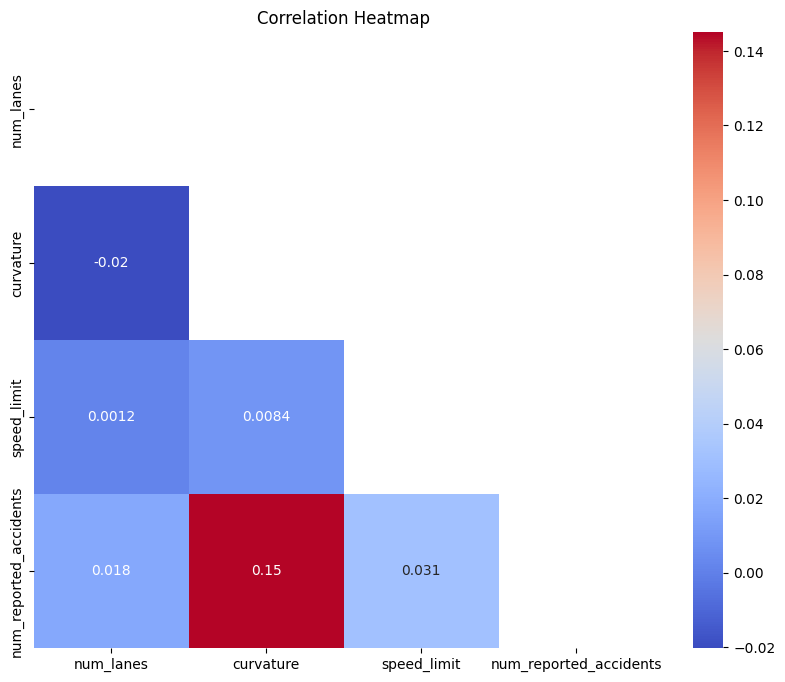

In [6]:
num_cols = train.select_dtypes(include=['int64', 'float64']).columns.drop(['id', 'accident_risk'])
train[num_cols].describe()

plt.figure(figsize=(10,8))
mask = np.triu(np.ones_like(train[num_cols].corr(), dtype=bool))
sns.heatmap(train[num_cols].corr(), mask=mask, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

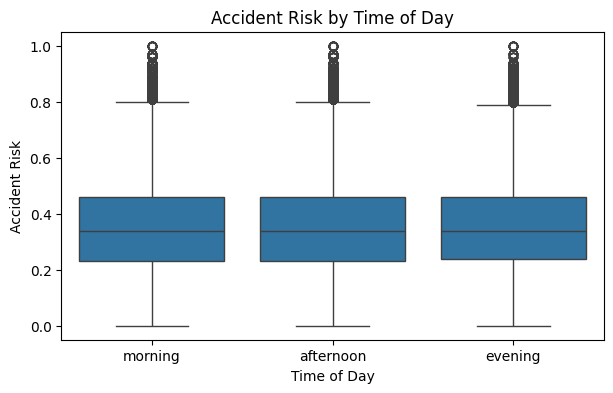

time_of_day
morning      0.350966
afternoon    0.351428
evening      0.354736
Name: accident_risk, dtype: float64


In [7]:
plt.figure(figsize=(7,4))
sns.boxplot(x='time_of_day', y='accident_risk', data=train, order=['morning','afternoon','evening'])
plt.title("Accident Risk by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Accident Risk")
plt.show()

# if you want average risk per time bucket:
mean_risk_by_time = train.groupby('time_of_day')['accident_risk'].mean().sort_values()
print(mean_risk_by_time)


Top numeric features correlated with accident_risk:

curvature                 0.543946
speed_limit               0.430898
num_reported_accidents    0.213891
num_lanes                -0.006003
dtype: float64


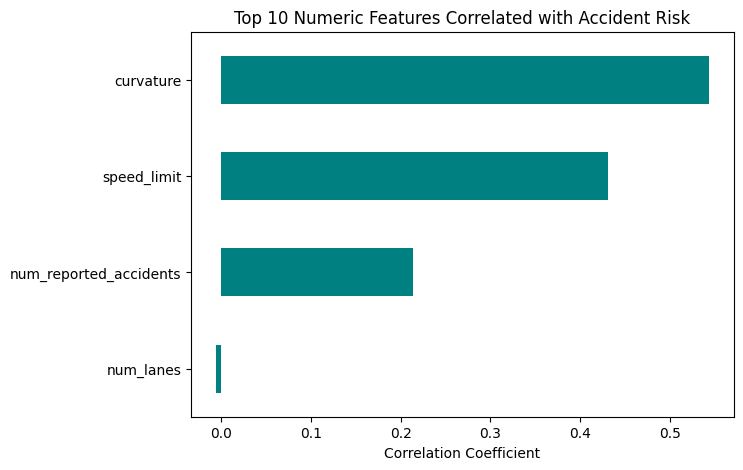

In [8]:
# Select only numeric columns (exclude id and target)
num_cols = train.select_dtypes(include=['int64', 'float64']).columns.drop(['id', 'accident_risk'])

# Compute correlation of each numeric column with the target
corrs = train[num_cols].corrwith(train['accident_risk']).sort_values(ascending=False)

# Display top correlations
print("\nTop numeric features correlated with accident_risk:\n")
print(corrs)

# Plot the top 10 for clarity
plt.figure(figsize=(7,5))
corrs.head(10).plot(kind='barh', color='teal')
plt.title("Top 10 Numeric Features Correlated with Accident Risk")
plt.xlabel("Correlation Coefficient")
plt.gca().invert_yaxis()
plt.show()

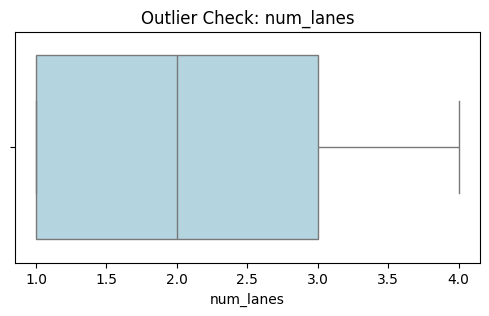

num_lanes - min: 1.00, 99th percentile: 4.00, max: 4.00


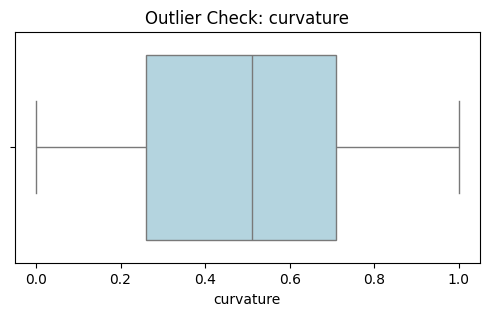

curvature - min: 0.00, 99th percentile: 0.98, max: 1.00


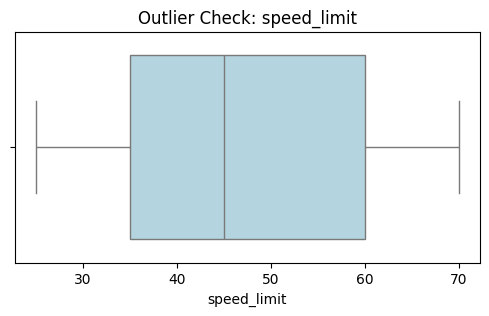

speed_limit - min: 25.00, 99th percentile: 70.00, max: 70.00


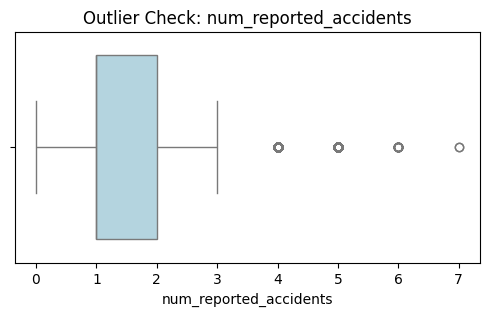

num_reported_accidents - min: 0.00, 99th percentile: 3.00, max: 7.00


In [9]:
# numeric columns except id/target
num_cols = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']

for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=train[col], color='lightblue')
    plt.title(f"Outlier Check: {col}")
    plt.show()

    # quick stats summary
    print(f"{col} - min: {train[col].min():.2f}, 99th percentile: {train[col].quantile(0.99):.2f}, max: {train[col].max():.2f}")

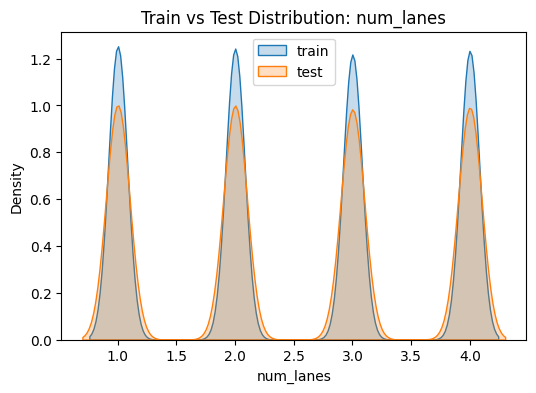

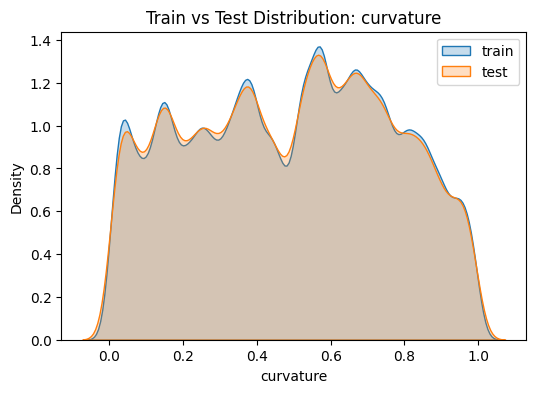

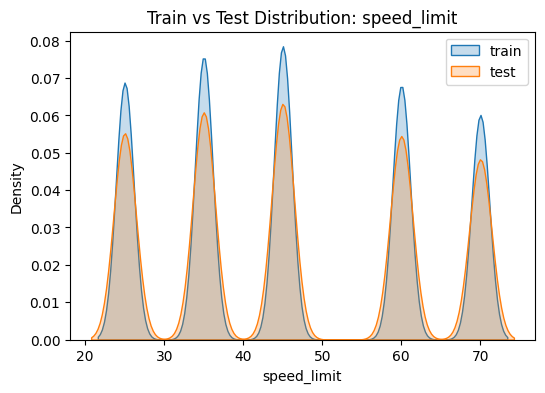

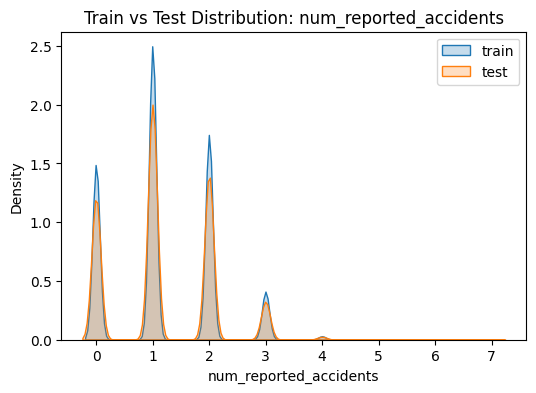

In [10]:
num_cols = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.kdeplot(train[col], label='train', fill=True, common_norm=False)
    sns.kdeplot(test[col], label='test', fill=True, common_norm=False)
    plt.title(f"Train vs Test Distribution: {col}")
    plt.legend()
    plt.show()

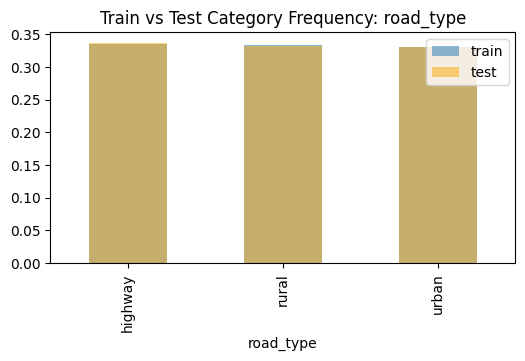

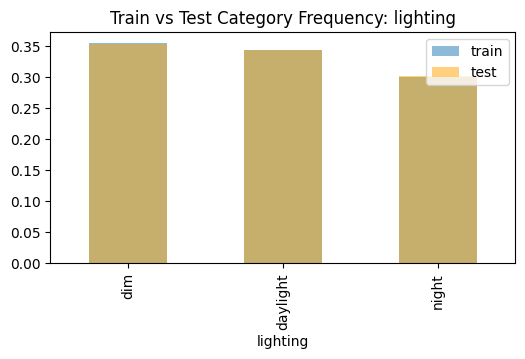

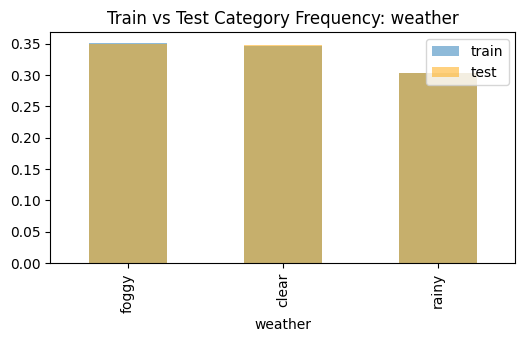

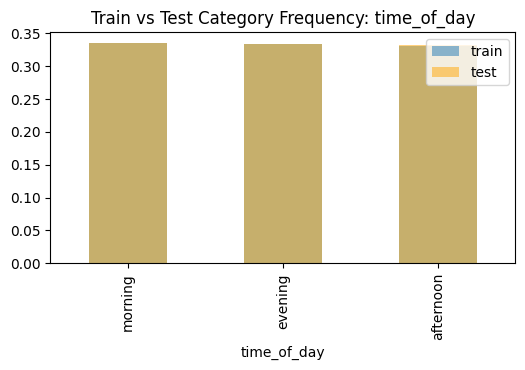

In [11]:
cat_cols = train.select_dtypes(include=['object']).columns

for col in cat_cols:
    plt.figure(figsize=(6,3))
    train[col].value_counts(normalize=True).plot(kind='bar', alpha=0.5, label='train')
    test[col].value_counts(normalize=True).plot(kind='bar', alpha=0.5, label='test', color='orange')
    plt.title(f"Train vs Test Category Frequency: {col}")
    plt.legend()
    plt.show()

In [4]:
train_cat = train.copy()
test_cat = test.copy()

cat_cols = ['road_type', 'lighting', 'weather', 'time_of_day']

for col in cat_cols:
    categories = pd.Categorical(pd.concat([train_cat[col], test_cat[col]], axis=0)).categories
    train_cat[col] = pd.Categorical(train_cat[col], categories=categories)
    test_cat[col] = pd.Categorical(test_cat[col], categories=categories)

In [5]:
X = train_cat.drop(columns=['id', 'accident_risk'])
y = train_cat['accident_risk']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Set up 5-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
test_X = test_cat.drop(columns=['id'])
test_preds_all = np.zeros(len(test_X))

In [7]:
# Loop through folds
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n===== Fold {fold + 1} / {kf.n_splits} =====")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Define model (tuned version)
    model = LGBMRegressor(
        n_estimators=4000,
        learning_rate=0.02,
        num_leaves=63,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_samples=50,
        reg_alpha=0.3,
        reg_lambda=0.3,
        random_state=42
    )

    # Train with early stopping
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        categorical_feature=cat_cols,
        callbacks=[early_stopping(stopping_rounds=200), log_evaluation(period=0)]
    )

    # Validation performance
    val_preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse:.5f}")

    # Average test predictions
    test_preds_all += model.predict(test_X) / kf.n_splits


===== Fold 1 / 5 =====
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 12
[LightGBM] [Info] Start training from score 0.352605
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1326]	valid_0's rmse: 0.0562126	valid_0's l2: 0.00315985
Fold 1 RMSE: 0.05621

===== Fold 2 / 5 =====
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 12
[LightGBM] [Info]

In [8]:
# Average RMSE
avg_rmse = np.mean(rmse_scores)
print("\n============================")
print(f"✅ Average RMSE across folds: {avg_rmse:.5f}")
print("============================")


✅ Average RMSE across folds: 0.05606


In [9]:
# Save final averaged predictions
submission = pd.DataFrame({
    'id': test_cat['id'],
    'accident_risk': test_preds_all
})
submission.to_csv('submission_kfold.csv', index=False)
print("✅ submission_kfold.csv ready for Kaggle upload!")

✅ submission_kfold.csv ready for Kaggle upload!
